https://keras.io/examples/generative/adain/

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers

# Defining the global variables.
IMAGE_SIZE = (96, 96)
BATCH_SIZE = 16
# Training for single epoch for time constraint.
# Please use atleast 30 epochs to see good results.
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

#make sure tf is 2.10, protobuf is 3.20 and tf datasets is 2.1.0

2023-07-24 13:05:28.820713: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 13:05:28.865736: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 13:05:28.867508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 13:05:29.757792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#tf.data pipeline
def decode_and_resize(image_path):
    """Decodes and resizes an image from the image file path.

    Args:
        image_path: The image file path.

    Returns:
        A resized image.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


# Get the image file paths for the style images.
s_p = r"/workspace/style/dashlit-transfer"
style_images = os.listdir(s_p)
style_images = [os.path.join(s_p, path) for path in style_images]

# Get the image file paths for the content images.
c_p = r"/workspace/style/taco-transfer"
content_images = os.listdir(c_p)
content_images = [os.path.join(c_p, path) for path in content_images]


# split the style images in train, val and test
total_style_images = len(style_images)
train_style = style_images[: int(0.8 * total_style_images)]
val_style = style_images[int(0.8 * total_style_images) : int(0.9 * total_style_images)]
test_style = style_images[int(0.9 * total_style_images) :]

# split the content images in train, val and test
total_content_images = len(content_images)
train_content = content_images[: int(0.8 * total_content_images)]
val_content = content_images[int(0.8 * total_content_images) : int(0.9 * total_content_images)]
test_content = content_images[int(0.9 * total_content_images) :]

# Build the style and content tf.data datasets.
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)


train_content_ds = (
    tf.data.Dataset.from_tensor_slices(train_content)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

val_content_ds = (
    tf.data.Dataset.from_tensor_slices(val_content)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

test_style_ds = (
    tf.data.Dataset.from_tensor_slices(test_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
test_content_ds = (
    tf.data.Dataset.from_tensor_slices(test_content)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)

# Zipping the style and content datasets.
train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.zip((test_style_ds, test_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

2023-07-24 13:05:33.021055: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


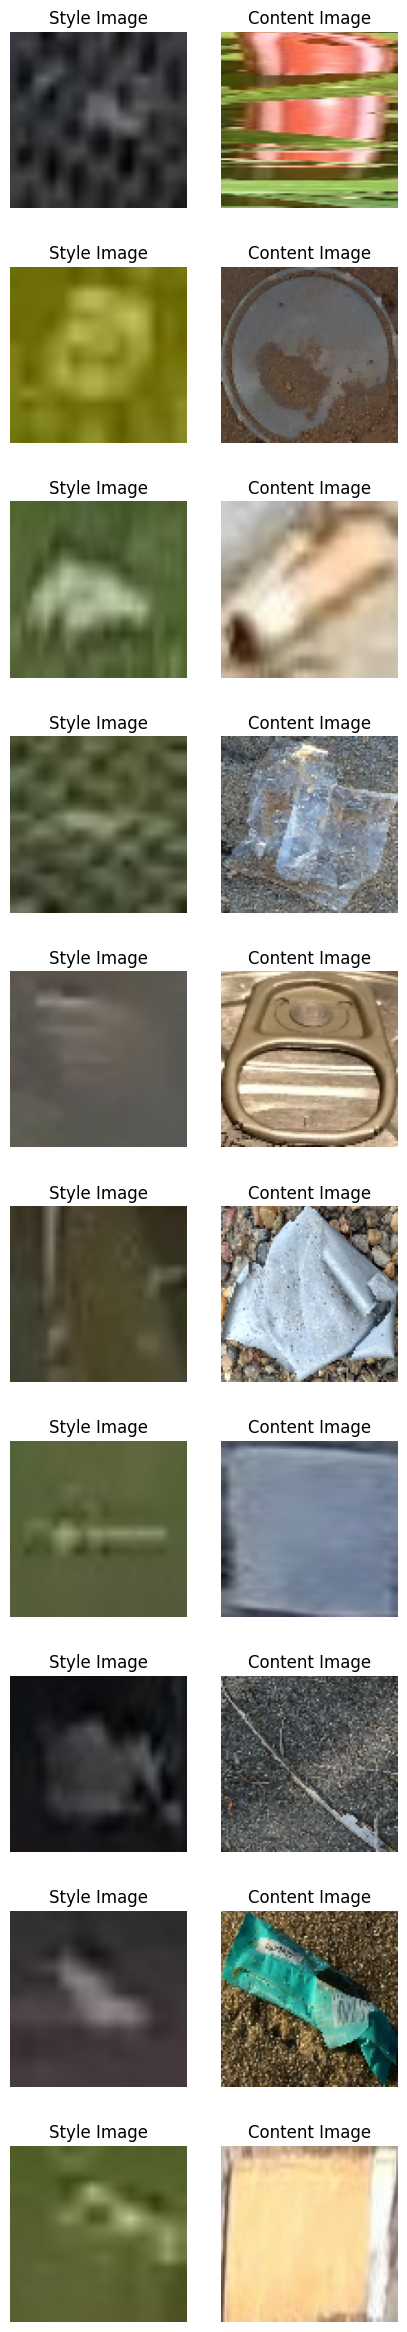

In [3]:
#visualising data
style, content = next(iter(train_ds))
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(5, 30))
[ax.axis("off") for ax in np.ravel(axes)]

for (axis, style_image, content_image) in zip(axes, style[0:10], content[0:10]):
    (ax_style, ax_content) = axis
    ax_style.imshow(style_image)
    ax_style.set_title("Style Image")

    ax_content.imshow(content_image)
    ax_content.set_title("Content Image")

In [4]:
def get_encoder():
    vgg19 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(*IMAGE_SIZE, 3),
    )
    vgg19.trainable = False
    mini_vgg19 = keras.Model(vgg19.input, vgg19.get_layer("block4_conv1").output)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="mini_vgg19")

In [5]:
def get_mean_std(x, epsilon=1e-5):
    axes = [1, 2]

    # Compute the mean and standard deviation of a tensor.
    mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
    standard_deviation = tf.sqrt(variance + epsilon)
    return mean, standard_deviation


def ada_in(style, content):
    """Computes the AdaIn feature map.

    Args:
        style: The style feature map.
        content: The content feature map.

    Returns:
        The AdaIN feature map.
    """
    content_mean, content_std = get_mean_std(content)
    style_mean, style_std = get_mean_std(style)
    t = style_std * (content - content_mean) / content_std + style_mean
    return t

In [6]:
def get_decoder():
    config = {"kernel_size": 3, "strides": 1, "padding": "same", "activation": "relu"}
    decoder = keras.Sequential(
        [
            layers.InputLayer((None, None, 512)),
            layers.Conv2D(filters=512, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=128, **config),
            layers.Conv2D(filters=128, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=64, **config),
            layers.Conv2D(
                filters=3,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="sigmoid",
            ),
        ]
    )
    return decoder

In [7]:
def get_loss_net():
    vgg19 = keras.applications.VGG19(
        include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3)
    )
    vgg19.trainable = False
    layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    outputs = [vgg19.get_layer(name).output for name in layer_names]
    mini_vgg19 = keras.Model(vgg19.input, outputs)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="loss_net")

In [8]:
class NeuralStyleTransfer(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_net, style_weight, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_net = loss_net
        self.style_weight = style_weight

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.style_loss_tracker = keras.metrics.Mean(name="style_loss")
        self.content_loss_tracker = keras.metrics.Mean(name="content_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        with tf.GradientTape() as tape:
            # Encode the style and content image.
            style_encoded = self.encoder(style)
            content_encoded = self.encoder(content)

            # Compute the AdaIN target feature maps.
            t = ada_in(style=style_encoded, content=content_encoded)

            # Generate the neural style transferred image.
            reconstructed_image = self.decoder(t)

            # Compute the losses.
            reconstructed_vgg_features = self.loss_net(reconstructed_image)
            style_vgg_features = self.loss_net(style)
            loss_content = self.loss_fn(t, reconstructed_vgg_features[-1])
            for inp, out in zip(style_vgg_features, reconstructed_vgg_features):
                mean_inp, std_inp = get_mean_std(inp)
                mean_out, std_out = get_mean_std(out)
                loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                    std_inp, std_out
                )
            loss_style = self.style_weight * loss_style
            total_loss = loss_content + loss_style

        # Compute gradients and optimize the decoder.
        trainable_vars = self.decoder.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        # Encode the style and content image.
        style_encoded = self.encoder(style)
        content_encoded = self.encoder(content)

        # Compute the AdaIN target feature maps.
        t = ada_in(style=style_encoded, content=content_encoded)

        # Generate the neural style transferred image.
        reconstructed_image = self.decoder(t)

        # Compute the losses.
        recons_vgg_features = self.loss_net(reconstructed_image)
        style_vgg_features = self.loss_net(style)
        loss_content = self.loss_fn(t, recons_vgg_features[-1])
        for inp, out in zip(style_vgg_features, recons_vgg_features):
            mean_inp, std_inp = get_mean_std(inp)
            mean_out, std_out = get_mean_std(out)
            loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                std_inp, std_out
            )
        loss_style = self.style_weight * loss_style
        total_loss = loss_content + loss_style

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [
            self.style_loss_tracker,
            self.content_loss_tracker,
            self.total_loss_tracker,
        ]

In [9]:
test_style, test_content = next(iter(test_ds))


class TrainMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Encode the style and content image.
        test_style_encoded = self.model.encoder(test_style)
        test_content_encoded = self.model.encoder(test_content)

        # Compute the AdaIN features.
        test_t = ada_in(style=test_style_encoded, content=test_content_encoded)
        test_reconstructed_image = self.model.decoder(test_t)

        # Plot the Style, Content and the NST image.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(tf.keras.utils.array_to_img(test_style[0]))
        ax[0].set_title(f"Style: {epoch:03d}")

        ax[1].imshow(tf.keras.utils.array_to_img(test_content[0]))
        ax[1].set_title(f"Content: {epoch:03d}")

        ax[2].imshow(
            tf.keras.utils.array_to_img(test_reconstructed_image[0])
        )
        ax[2].set_title(f"NST: {epoch:03d}")

        plt.show()
        plt.close()

Epoch 1/30
50/50 [==============================] - ETA: 0s - style_loss: 164.8382 - content_loss: 86.1035 - total_loss: 250.9417

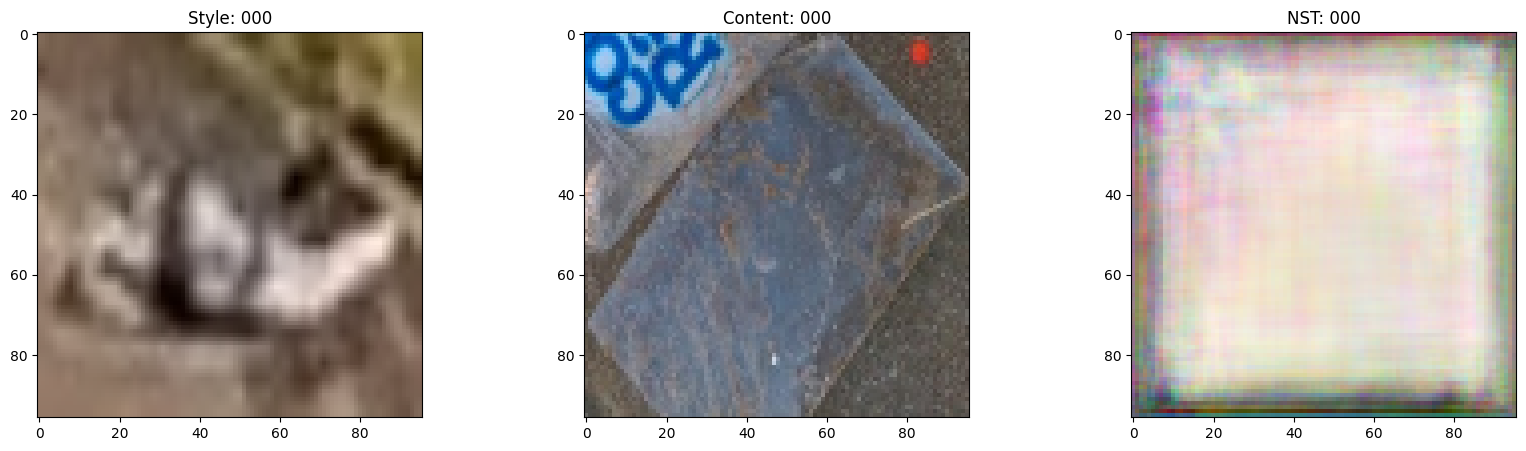

50/50 [==============================] - 130s 3s/step - style_loss: 164.8382 - content_loss: 86.1035 - total_loss: 250.9417 - val_style_loss: 86.0342 - val_content_loss: 63.6846 - val_total_loss: 149.7188
Epoch 2/30
50/50 [==============================] - ETA: 0s - style_loss: 68.8450 - content_loss: 56.1315 - total_loss: 124.9765

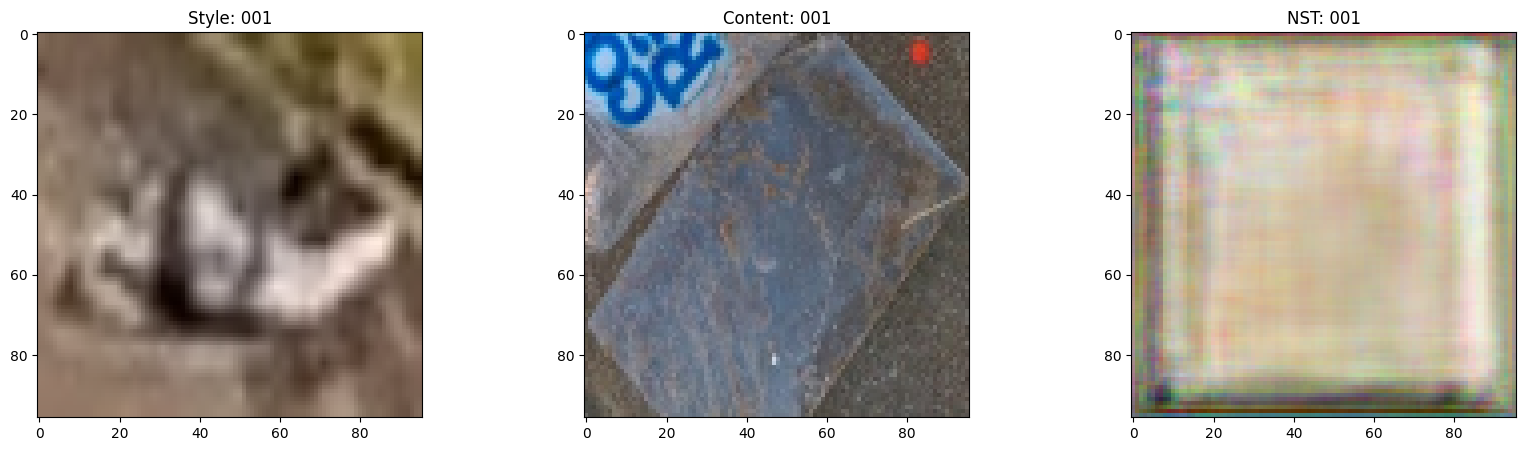

50/50 [==============================] - 121s 2s/step - style_loss: 68.8450 - content_loss: 56.1315 - total_loss: 124.9765 - val_style_loss: 57.1176 - val_content_loss: 51.5555 - val_total_loss: 108.6730
Epoch 3/30
50/50 [==============================] - ETA: 0s - style_loss: 49.4585 - content_loss: 48.6107 - total_loss: 98.0692

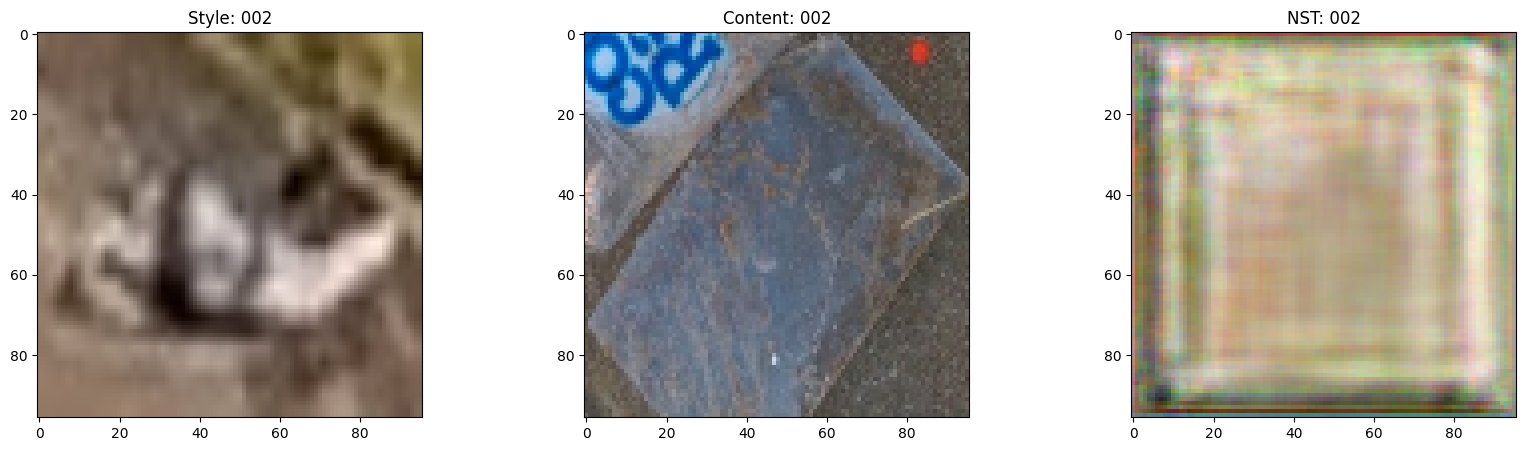

50/50 [==============================] - 122s 2s/step - style_loss: 49.4585 - content_loss: 48.6107 - total_loss: 98.0692 - val_style_loss: 42.2215 - val_content_loss: 46.7192 - val_total_loss: 88.9407
Epoch 4/30
50/50 [==============================] - ETA: 0s - style_loss: 36.5595 - content_loss: 43.9066 - total_loss: 80.4661

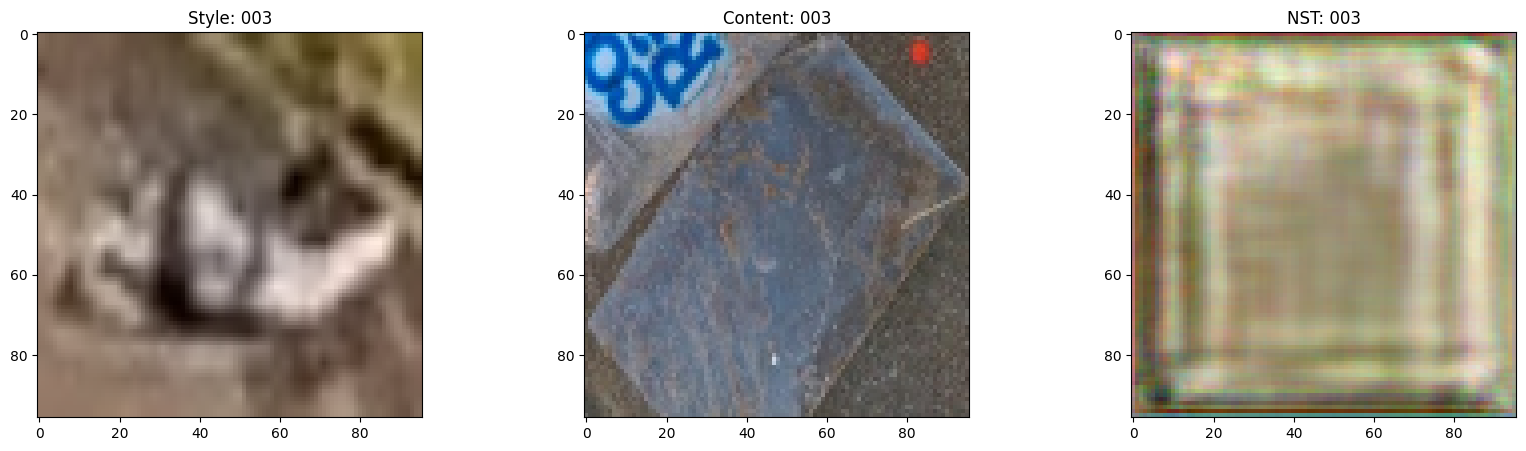

50/50 [==============================] - 123s 2s/step - style_loss: 36.5595 - content_loss: 43.9066 - total_loss: 80.4661 - val_style_loss: 33.1989 - val_content_loss: 43.6239 - val_total_loss: 76.8228
Epoch 5/30
50/50 [==============================] - ETA: 0s - style_loss: 30.0771 - content_loss: 41.4922 - total_loss: 71.5692

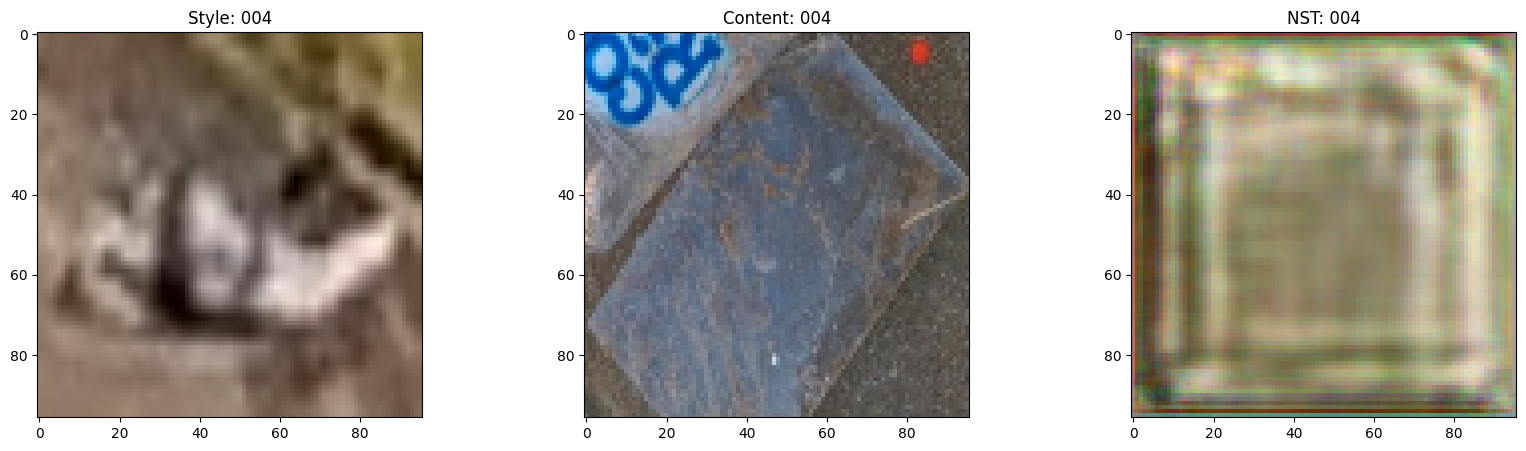

50/50 [==============================] - 120s 2s/step - style_loss: 30.0771 - content_loss: 41.4922 - total_loss: 71.5692 - val_style_loss: 27.3564 - val_content_loss: 41.0866 - val_total_loss: 68.4431
Epoch 6/30
50/50 [==============================] - ETA: 0s - style_loss: 24.4407 - content_loss: 38.2610 - total_loss: 62.7017

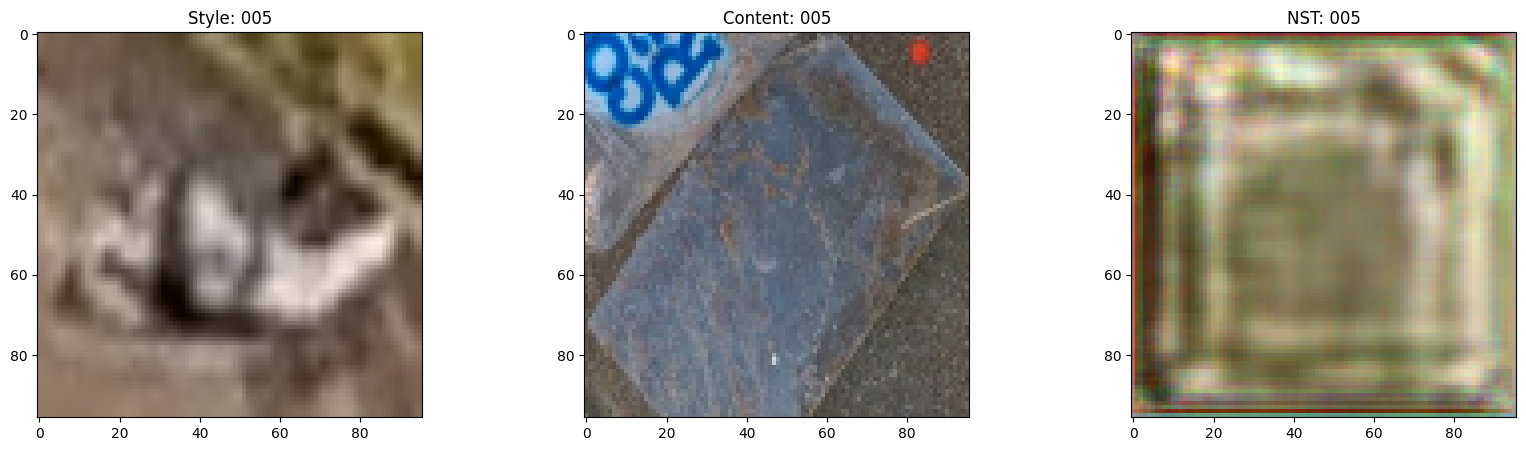

50/50 [==============================] - 121s 2s/step - style_loss: 24.4407 - content_loss: 38.2610 - total_loss: 62.7017 - val_style_loss: 24.0908 - val_content_loss: 38.6356 - val_total_loss: 62.7264
Epoch 7/30
50/50 [==============================] - ETA: 0s - style_loss: 22.0292 - content_loss: 37.0032 - total_loss: 59.0324

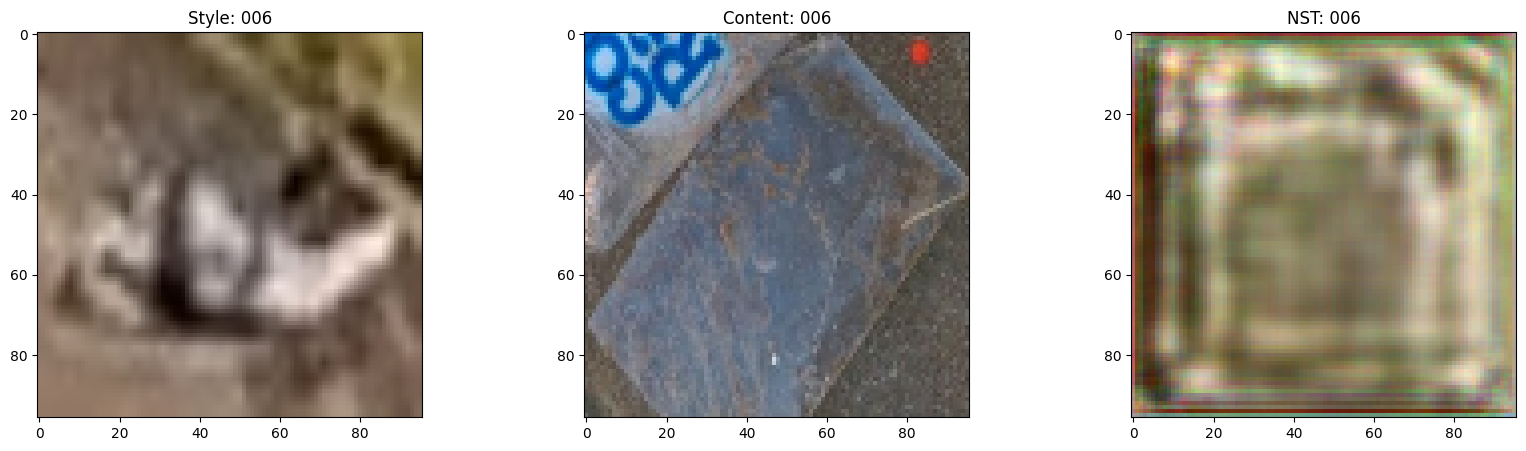

50/50 [==============================] - 122s 2s/step - style_loss: 22.0292 - content_loss: 37.0032 - total_loss: 59.0324 - val_style_loss: 21.9425 - val_content_loss: 37.3118 - val_total_loss: 59.2543
Epoch 8/30
50/50 [==============================] - ETA: 0s - style_loss: 20.4678 - content_loss: 36.0979 - total_loss: 56.5657

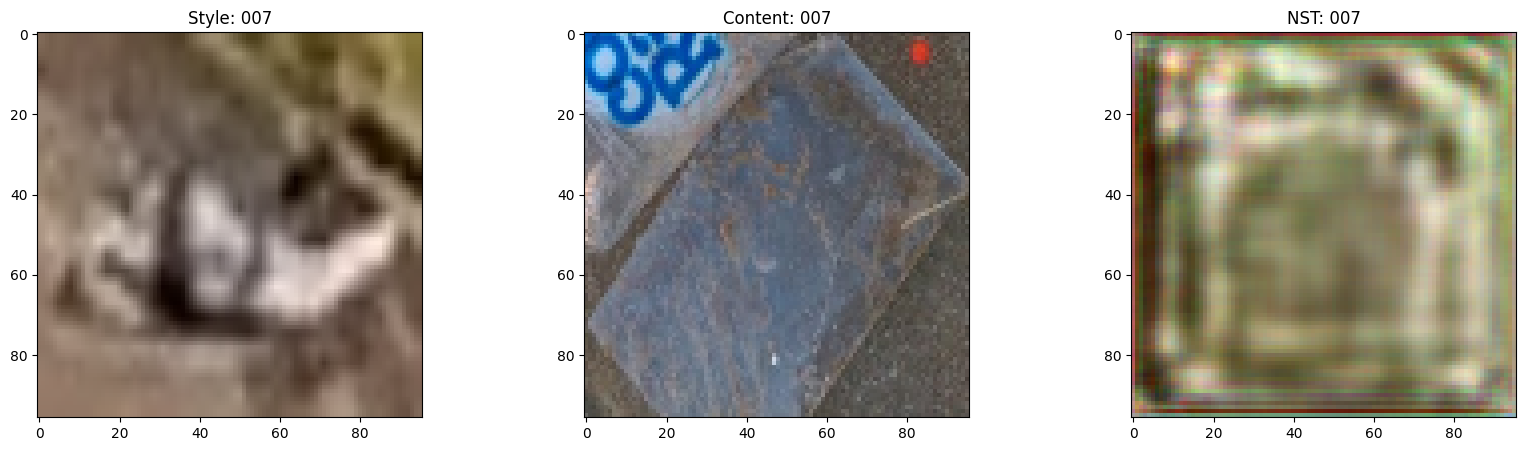

50/50 [==============================] - 121s 2s/step - style_loss: 20.4678 - content_loss: 36.0979 - total_loss: 56.5657 - val_style_loss: 20.3500 - val_content_loss: 36.3165 - val_total_loss: 56.6665
Epoch 9/30
50/50 [==============================] - ETA: 0s - style_loss: 19.7162 - content_loss: 35.0501 - total_loss: 54.7663

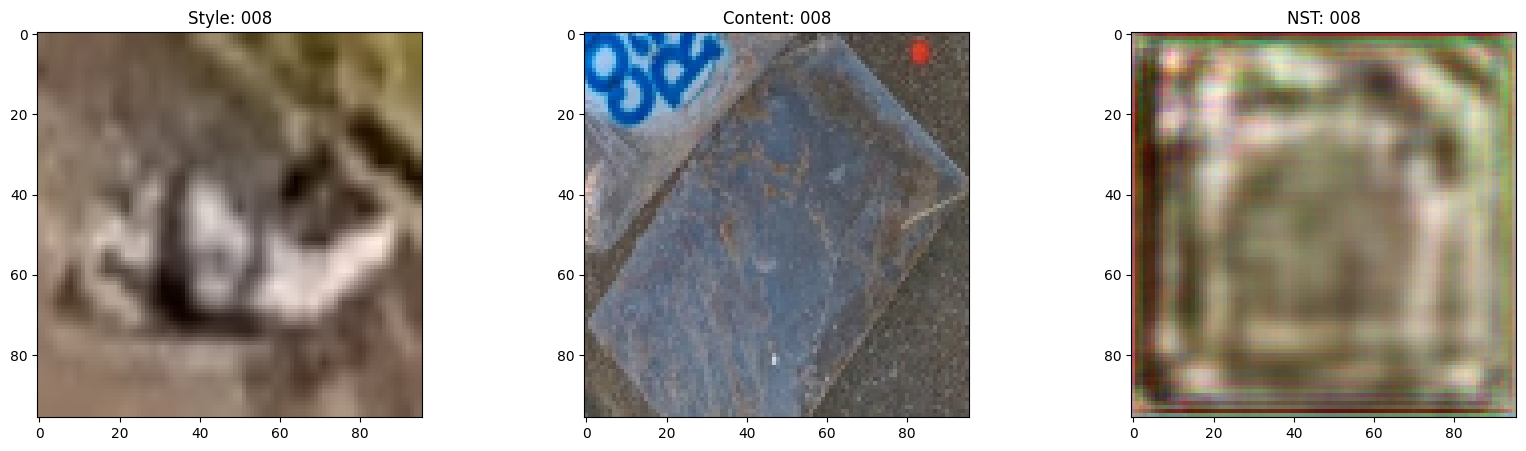

50/50 [==============================] - 123s 2s/step - style_loss: 19.7162 - content_loss: 35.0501 - total_loss: 54.7663 - val_style_loss: 19.2227 - val_content_loss: 35.5810 - val_total_loss: 54.8036
Epoch 10/30
50/50 [==============================] - ETA: 0s - style_loss: 19.4368 - content_loss: 34.5017 - total_loss: 53.9385

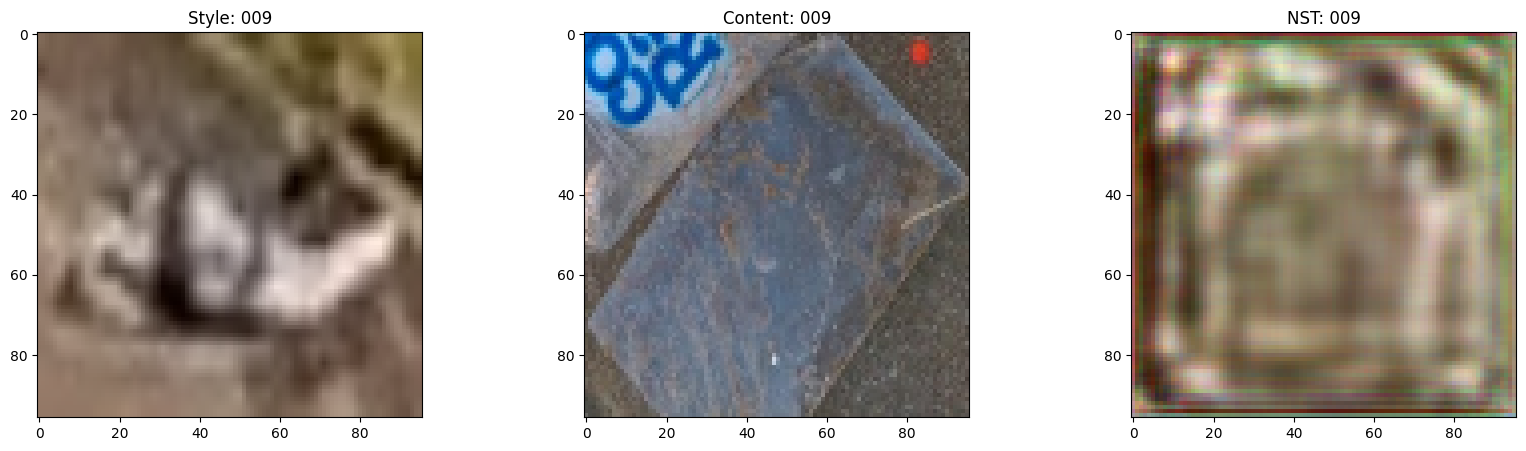

50/50 [==============================] - 125s 3s/step - style_loss: 19.4368 - content_loss: 34.5017 - total_loss: 53.9385 - val_style_loss: 18.4543 - val_content_loss: 34.9922 - val_total_loss: 53.4465
Epoch 11/30
50/50 [==============================] - ETA: 0s - style_loss: 18.2285 - content_loss: 34.3413 - total_loss: 52.5698

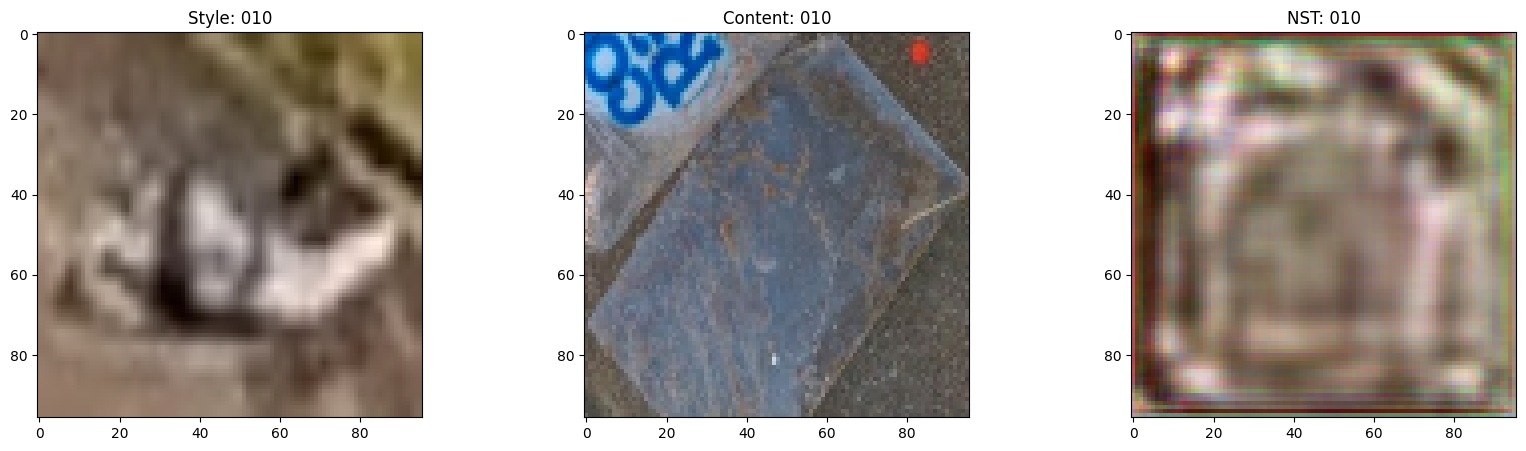

50/50 [==============================] - 125s 3s/step - style_loss: 18.2285 - content_loss: 34.3413 - total_loss: 52.5698 - val_style_loss: 17.6613 - val_content_loss: 34.6089 - val_total_loss: 52.2702
Epoch 12/30
50/50 [==============================] - ETA: 0s - style_loss: 17.2259 - content_loss: 33.1959 - total_loss: 50.4218

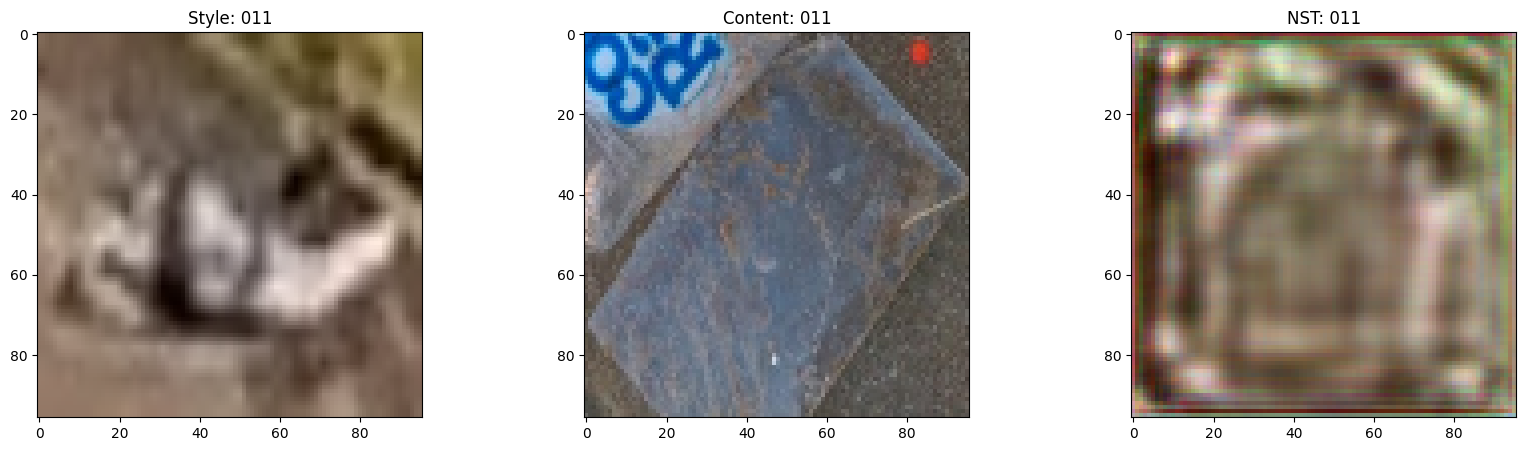

50/50 [==============================] - 122s 2s/step - style_loss: 17.2259 - content_loss: 33.1959 - total_loss: 50.4218 - val_style_loss: 17.5471 - val_content_loss: 33.5169 - val_total_loss: 51.0640
Epoch 13/30
50/50 [==============================] - ETA: 0s - style_loss: 16.6753 - content_loss: 32.5022 - total_loss: 49.1776

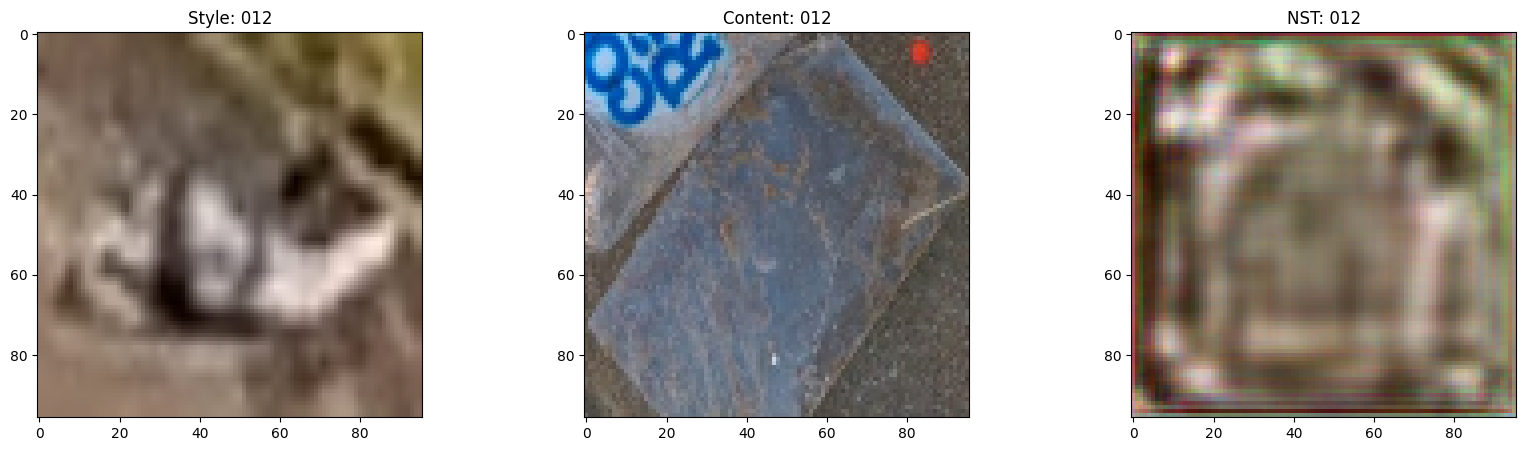

50/50 [==============================] - 121s 2s/step - style_loss: 16.6753 - content_loss: 32.5022 - total_loss: 49.1776 - val_style_loss: 16.7997 - val_content_loss: 33.1470 - val_total_loss: 49.9468
Epoch 14/30
50/50 [==============================] - ETA: 0s - style_loss: 15.8379 - content_loss: 32.0590 - total_loss: 47.8969

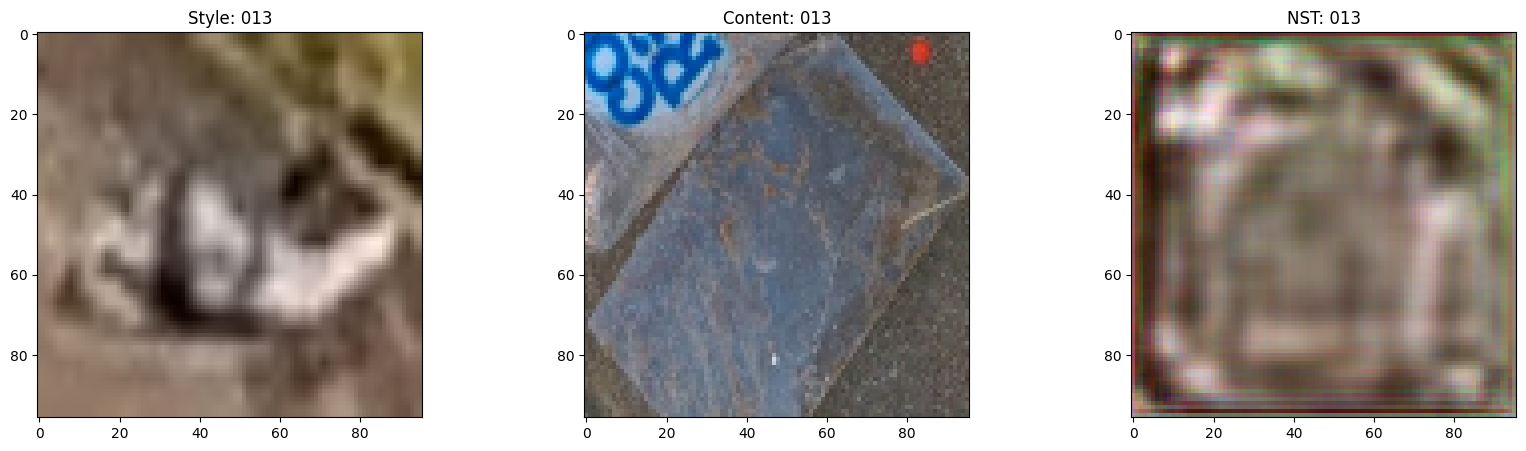

50/50 [==============================] - 120s 2s/step - style_loss: 15.8379 - content_loss: 32.0590 - total_loss: 47.8969 - val_style_loss: 16.2810 - val_content_loss: 33.0735 - val_total_loss: 49.3544
Epoch 15/30
50/50 [==============================] - ETA: 0s - style_loss: 15.4963 - content_loss: 31.7431 - total_loss: 47.2395

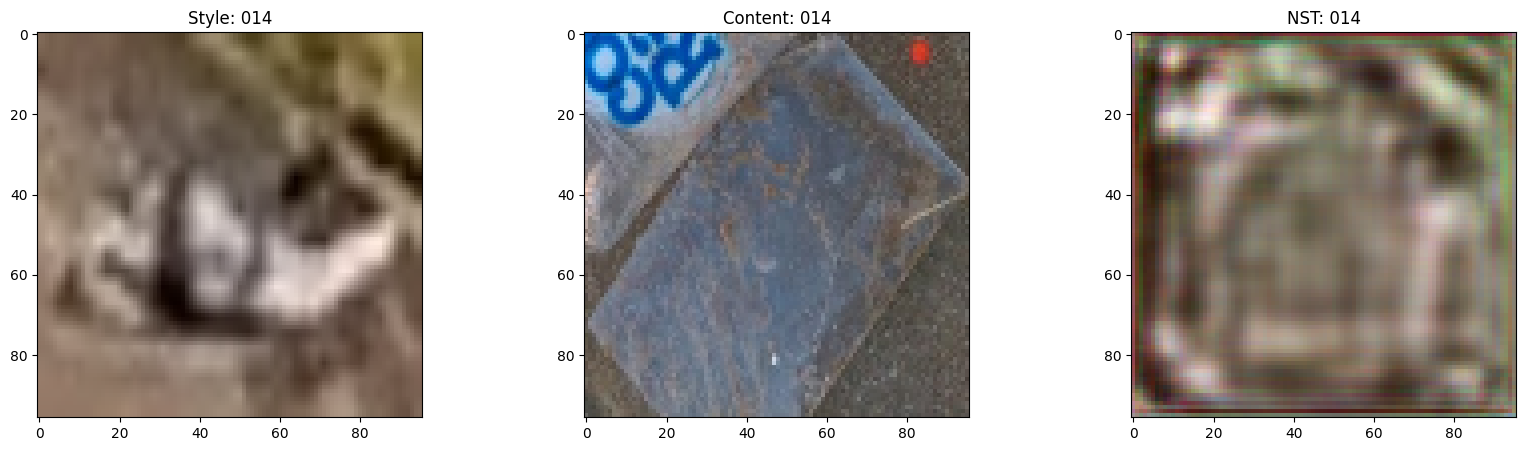

50/50 [==============================] - 119s 2s/step - style_loss: 15.4963 - content_loss: 31.7431 - total_loss: 47.2395 - val_style_loss: 16.0065 - val_content_loss: 32.5932 - val_total_loss: 48.5996
Epoch 16/30
50/50 [==============================] - ETA: 0s - style_loss: 15.0818 - content_loss: 31.2348 - total_loss: 46.3167

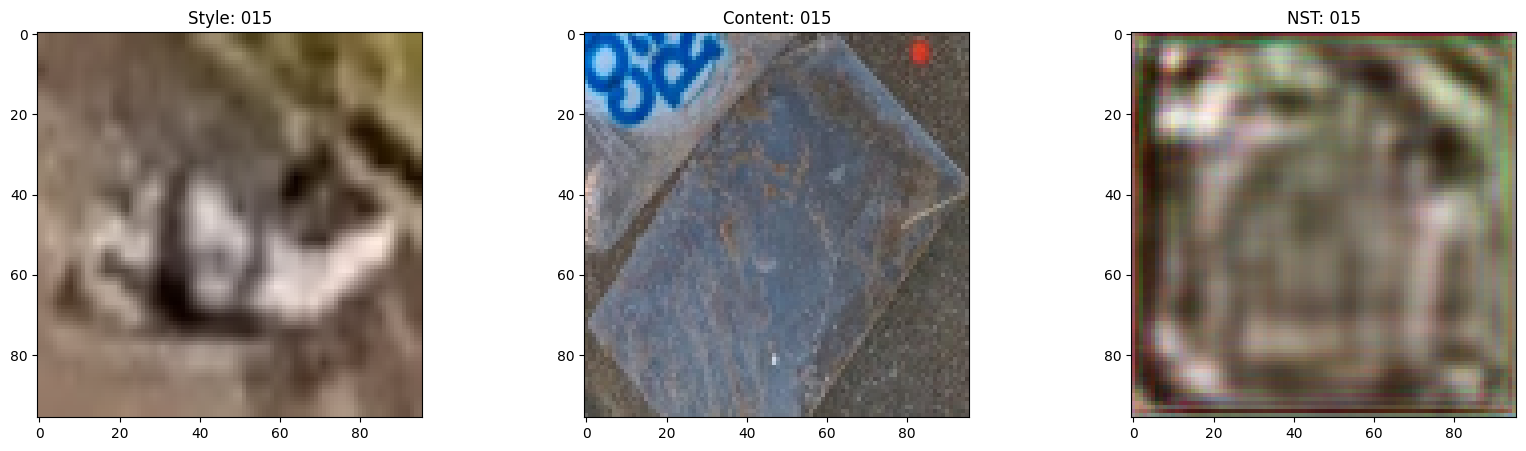

50/50 [==============================] - 122s 2s/step - style_loss: 15.0818 - content_loss: 31.2348 - total_loss: 46.3167 - val_style_loss: 15.6984 - val_content_loss: 32.1000 - val_total_loss: 47.7984
Epoch 17/30
50/50 [==============================] - ETA: 0s - style_loss: 15.2484 - content_loss: 31.4837 - total_loss: 46.7322

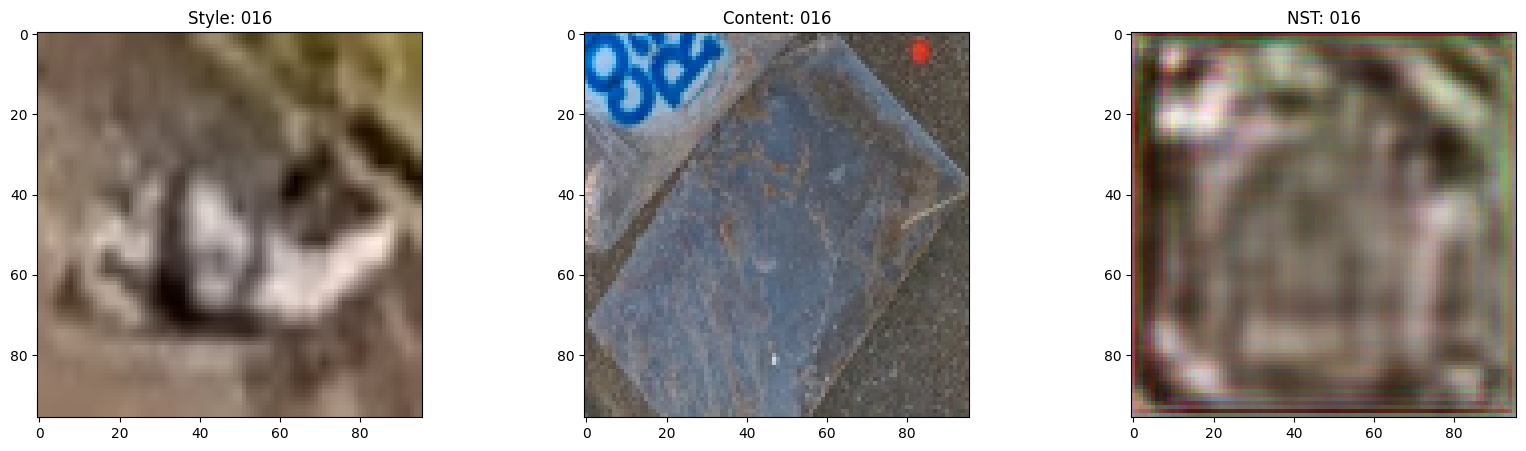

50/50 [==============================] - 120s 2s/step - style_loss: 15.2484 - content_loss: 31.4837 - total_loss: 46.7322 - val_style_loss: 15.2360 - val_content_loss: 31.8224 - val_total_loss: 47.0584
Epoch 18/30
50/50 [==============================] - ETA: 0s - style_loss: 15.9994 - content_loss: 31.4709 - total_loss: 47.4703

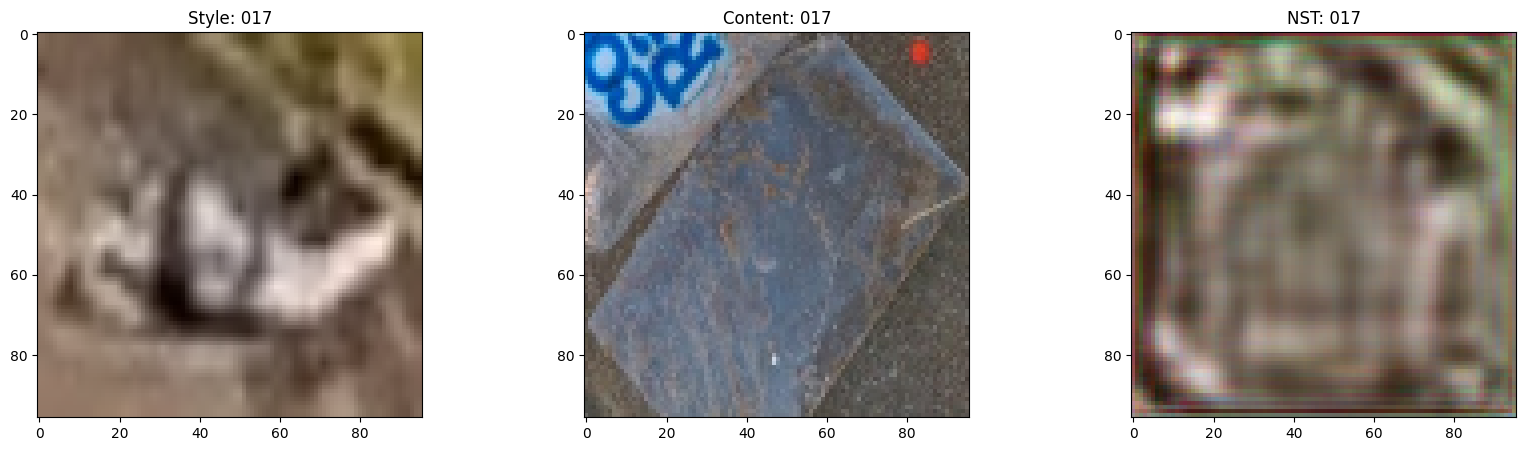

50/50 [==============================] - 122s 2s/step - style_loss: 15.9994 - content_loss: 31.4709 - total_loss: 47.4703 - val_style_loss: 15.2109 - val_content_loss: 31.6462 - val_total_loss: 46.8572
Epoch 19/30
50/50 [==============================] - ETA: 0s - style_loss: 14.6710 - content_loss: 30.8728 - total_loss: 45.5438

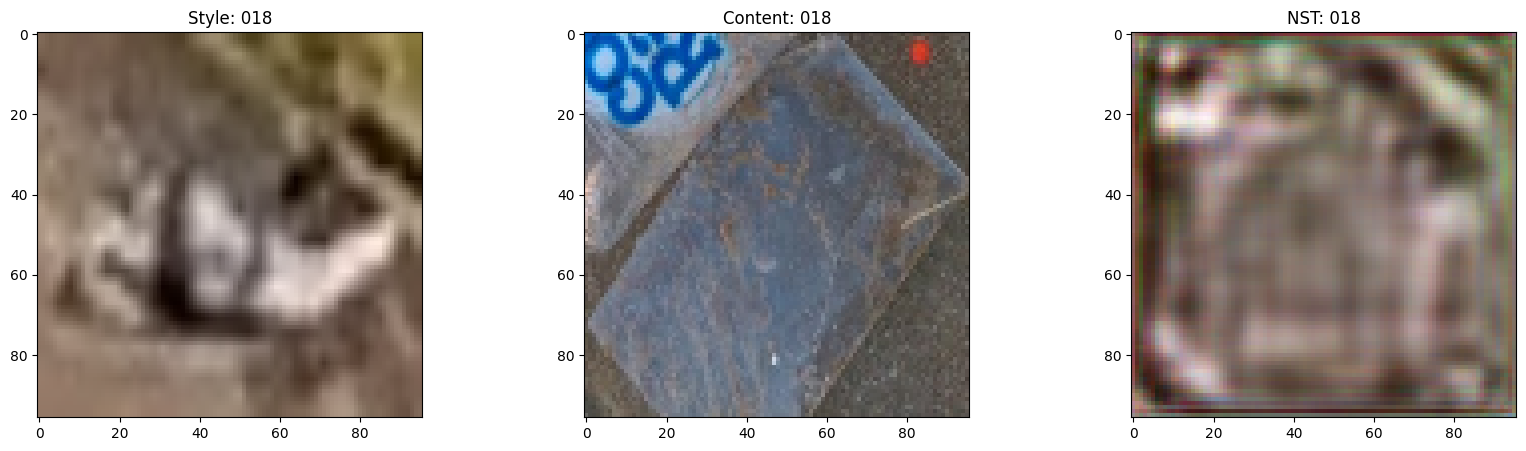

50/50 [==============================] - 119s 2s/step - style_loss: 14.6710 - content_loss: 30.8728 - total_loss: 45.5438 - val_style_loss: 14.8022 - val_content_loss: 31.4084 - val_total_loss: 46.2106
Epoch 20/30
50/50 [==============================] - ETA: 0s - style_loss: 14.6829 - content_loss: 30.8533 - total_loss: 45.5362

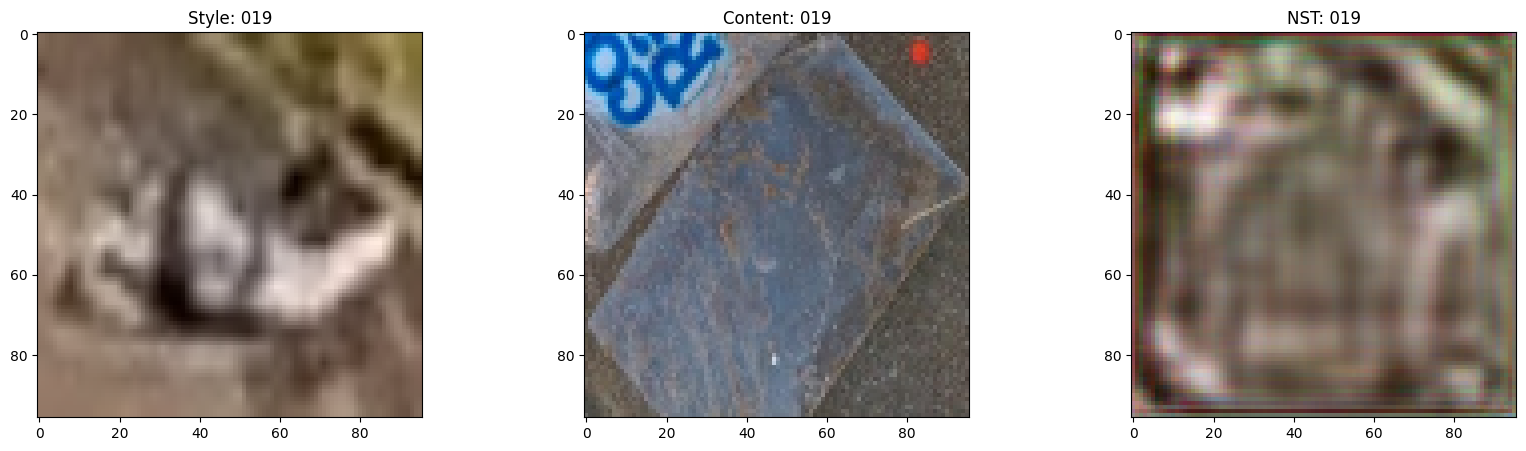

50/50 [==============================] - 119s 2s/step - style_loss: 14.6829 - content_loss: 30.8533 - total_loss: 45.5362 - val_style_loss: 14.6811 - val_content_loss: 30.9604 - val_total_loss: 45.6415
Epoch 21/30
50/50 [==============================] - ETA: 0s - style_loss: 14.4829 - content_loss: 30.2910 - total_loss: 44.7739

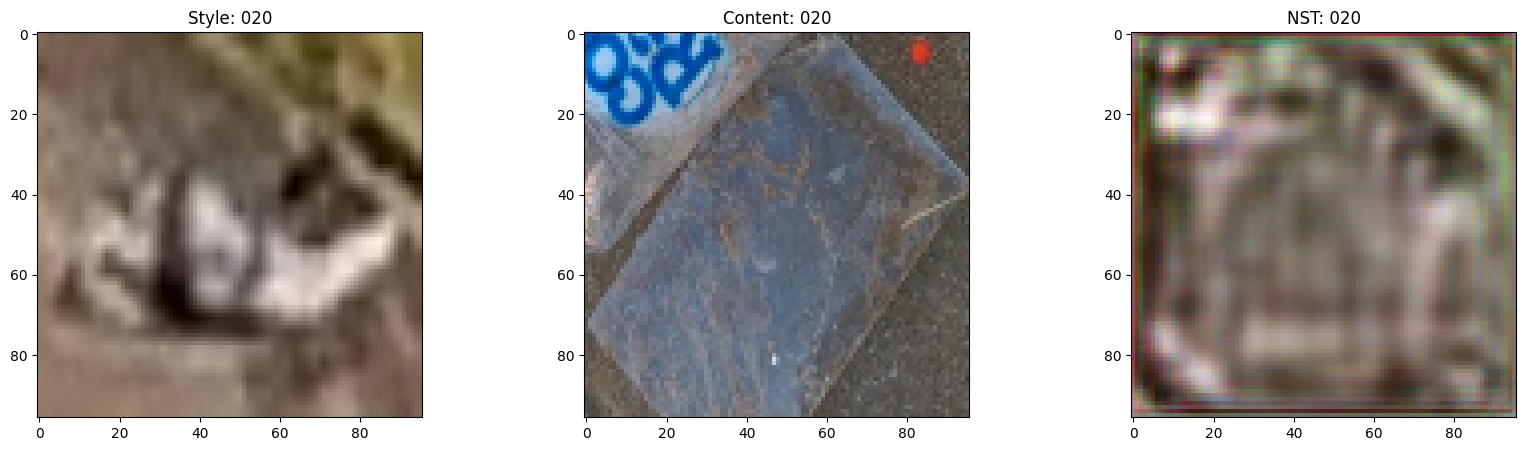

50/50 [==============================] - 119s 2s/step - style_loss: 14.4829 - content_loss: 30.2910 - total_loss: 44.7739 - val_style_loss: 14.4822 - val_content_loss: 30.9592 - val_total_loss: 45.4413
Epoch 22/30
50/50 [==============================] - ETA: 0s - style_loss: 14.1987 - content_loss: 29.8063 - total_loss: 44.0049

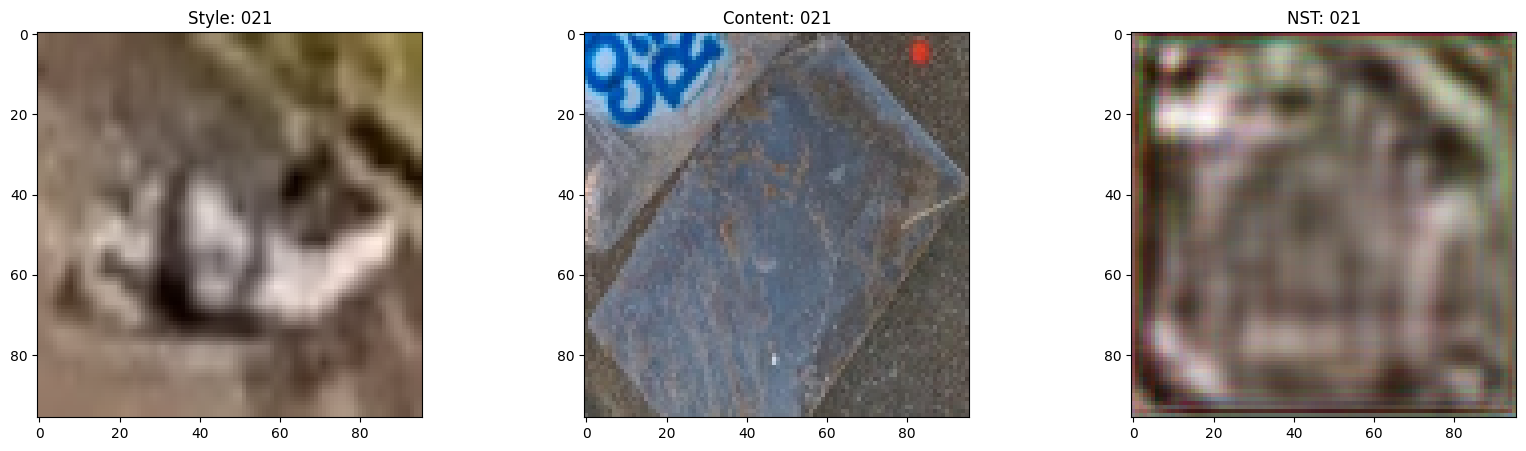

50/50 [==============================] - 120s 2s/step - style_loss: 14.1987 - content_loss: 29.8063 - total_loss: 44.0049 - val_style_loss: 14.3426 - val_content_loss: 30.7121 - val_total_loss: 45.0546
Epoch 23/30
50/50 [==============================] - ETA: 0s - style_loss: 13.3759 - content_loss: 29.8328 - total_loss: 43.2086

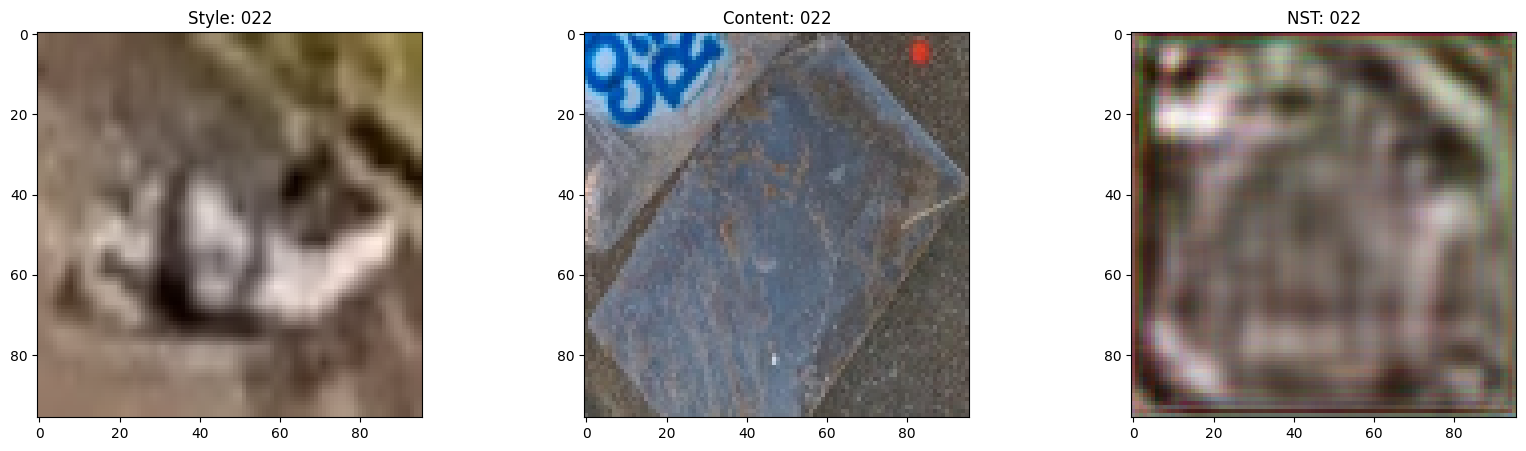

50/50 [==============================] - 123s 2s/step - style_loss: 13.3759 - content_loss: 29.8328 - total_loss: 43.2086 - val_style_loss: 14.1892 - val_content_loss: 30.3996 - val_total_loss: 44.5888
Epoch 24/30
50/50 [==============================] - ETA: 0s - style_loss: 13.5075 - content_loss: 29.5915 - total_loss: 43.0990

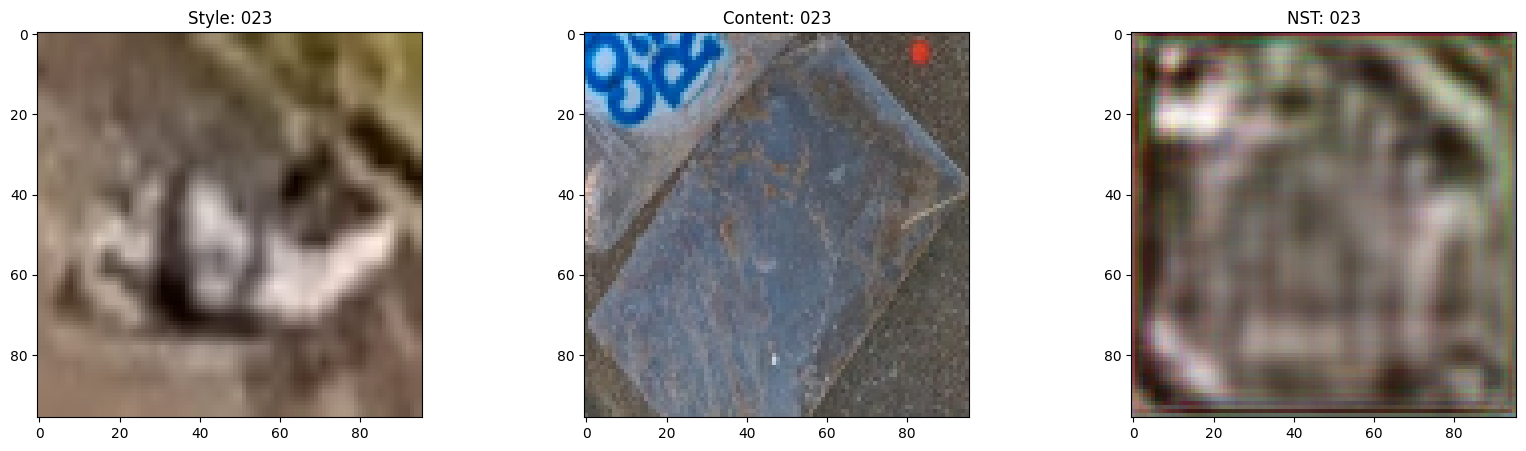

50/50 [==============================] - 121s 2s/step - style_loss: 13.5075 - content_loss: 29.5915 - total_loss: 43.0990 - val_style_loss: 13.8807 - val_content_loss: 30.3406 - val_total_loss: 44.2213
Epoch 25/30
50/50 [==============================] - ETA: 0s - style_loss: 13.8529 - content_loss: 29.4002 - total_loss: 43.2530

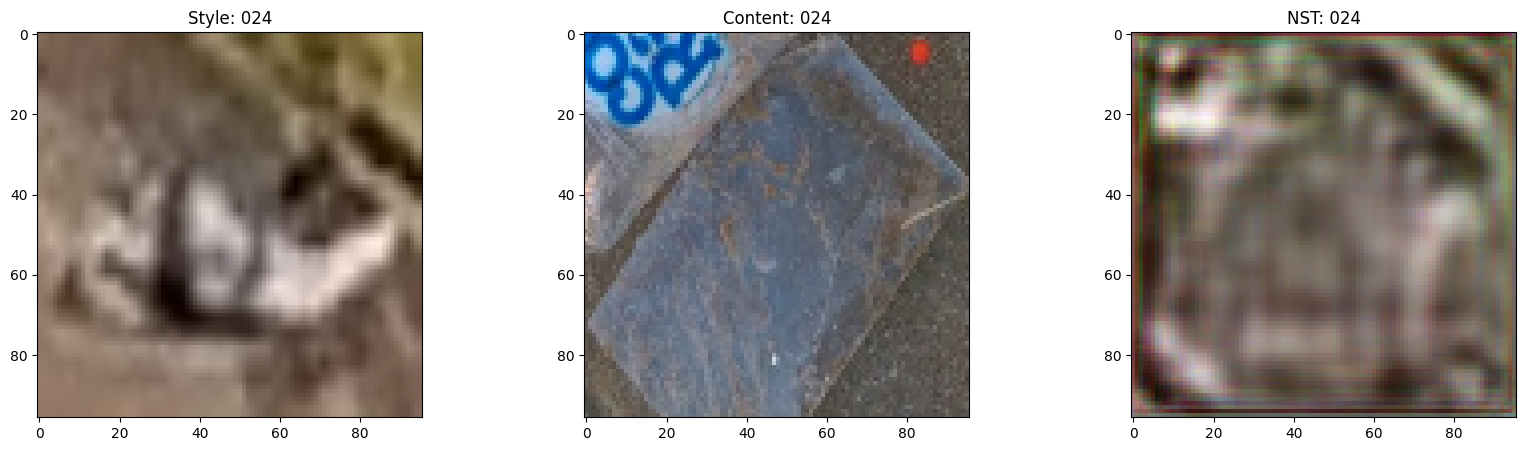

50/50 [==============================] - 122s 2s/step - style_loss: 13.8529 - content_loss: 29.4002 - total_loss: 43.2530 - val_style_loss: 13.8220 - val_content_loss: 30.0278 - val_total_loss: 43.8498
Epoch 26/30
50/50 [==============================] - ETA: 0s - style_loss: 14.2889 - content_loss: 29.9477 - total_loss: 44.2366

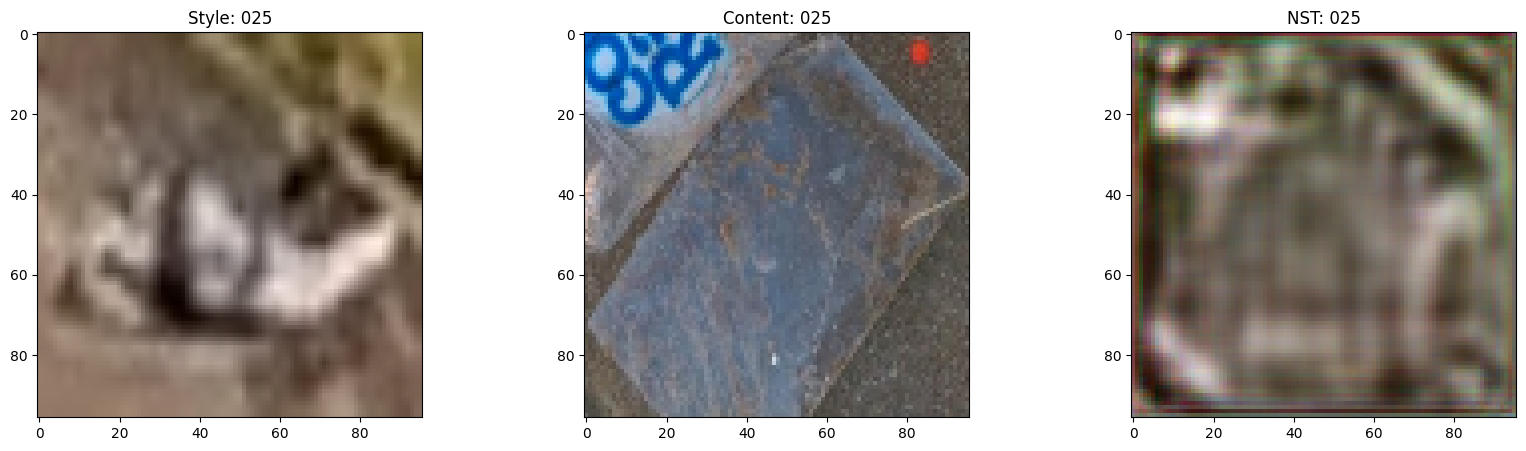

50/50 [==============================] - 122s 2s/step - style_loss: 14.2889 - content_loss: 29.9477 - total_loss: 44.2366 - val_style_loss: 13.7056 - val_content_loss: 29.9897 - val_total_loss: 43.6953
Epoch 27/30
50/50 [==============================] - ETA: 0s - style_loss: 13.5535 - content_loss: 29.7731 - total_loss: 43.3266

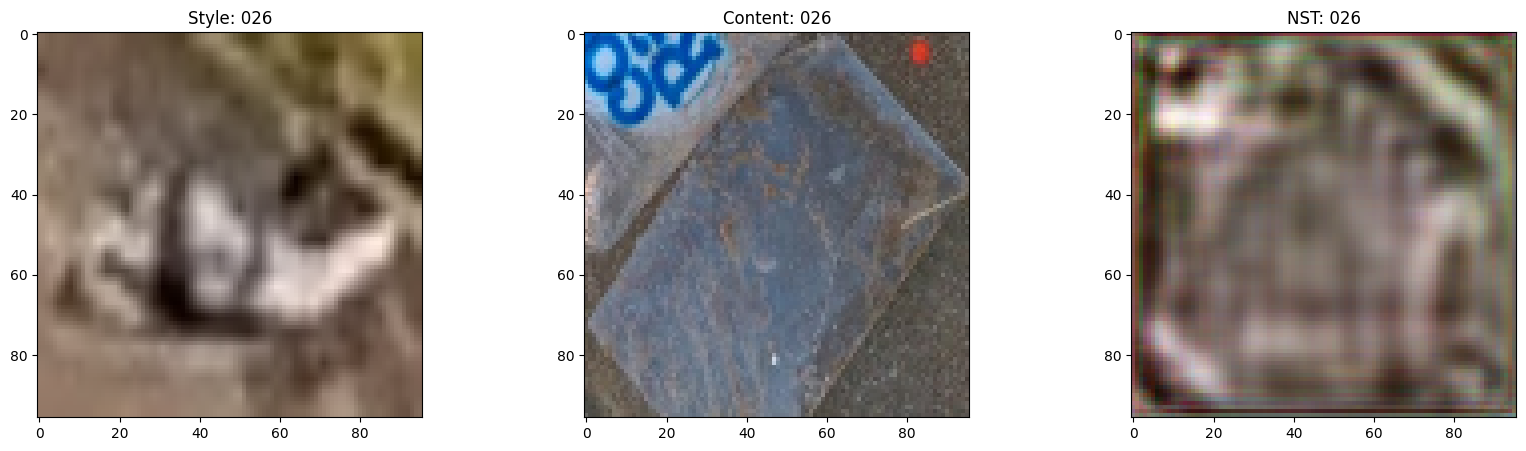

50/50 [==============================] - 122s 2s/step - style_loss: 13.5535 - content_loss: 29.7731 - total_loss: 43.3266 - val_style_loss: 13.5505 - val_content_loss: 29.8978 - val_total_loss: 43.4483
Epoch 28/30
50/50 [==============================] - ETA: 0s - style_loss: 13.3840 - content_loss: 28.9046 - total_loss: 42.2887

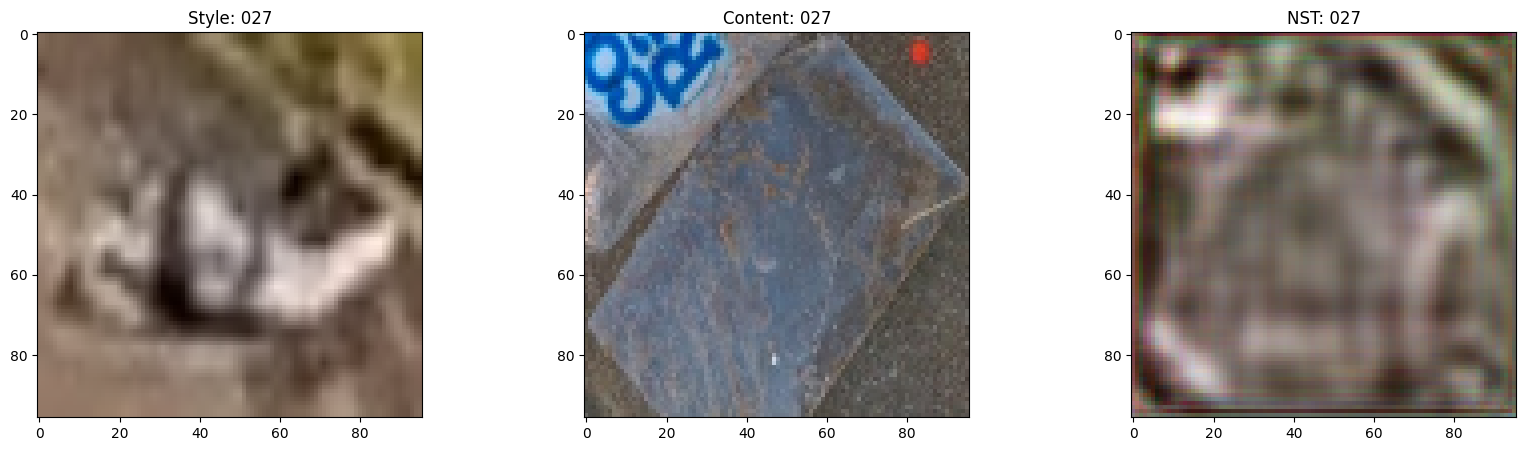

50/50 [==============================] - 119s 2s/step - style_loss: 13.3840 - content_loss: 28.9046 - total_loss: 42.2887 - val_style_loss: 13.3614 - val_content_loss: 29.6670 - val_total_loss: 43.0284
Epoch 29/30
50/50 [==============================] - ETA: 0s - style_loss: 12.9076 - content_loss: 29.0750 - total_loss: 41.9826

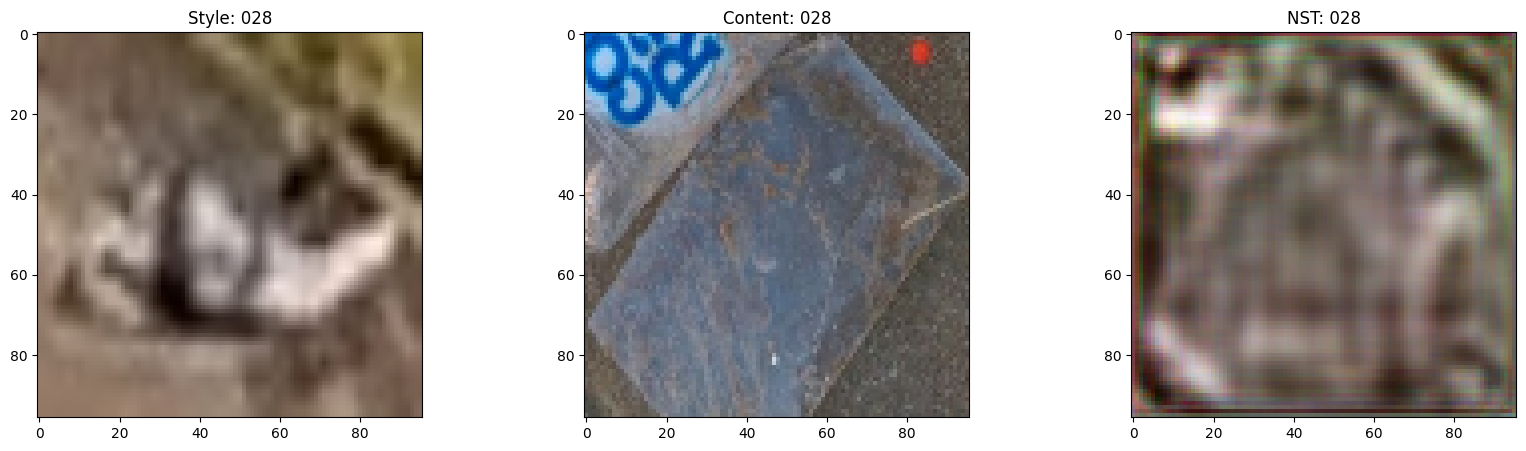

50/50 [==============================] - 120s 2s/step - style_loss: 12.9076 - content_loss: 29.0750 - total_loss: 41.9826 - val_style_loss: 13.2059 - val_content_loss: 29.6447 - val_total_loss: 42.8506
Epoch 30/30
50/50 [==============================] - ETA: 0s - style_loss: 12.4473 - content_loss: 28.4063 - total_loss: 40.8536

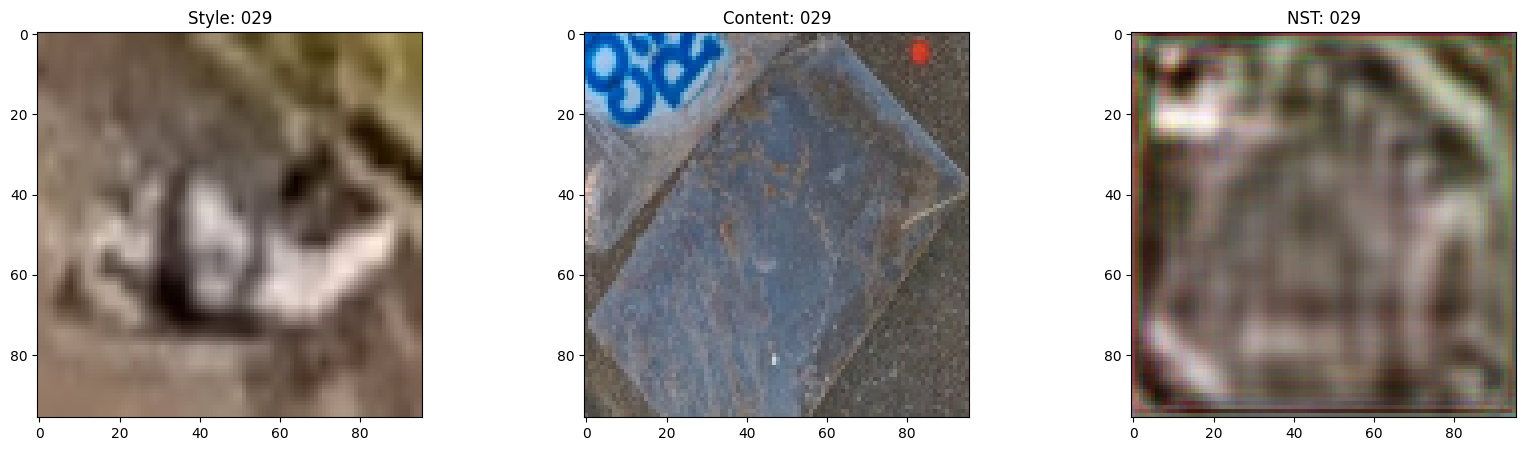

50/50 [==============================] - 122s 2s/step - style_loss: 12.4473 - content_loss: 28.4063 - total_loss: 40.8536 - val_style_loss: 13.3587 - val_content_loss: 29.4848 - val_total_loss: 42.8434


In [10]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = keras.losses.MeanSquaredError()

encoder = get_encoder()
loss_net = get_loss_net()
decoder = get_decoder()

model = NeuralStyleTransfer(
    encoder=encoder, decoder=decoder, loss_net=loss_net, style_weight=4.0
)

model.compile(optimizer=optimizer, loss_fn=loss_fn)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=50,
    validation_data=val_ds,
    validation_steps=50,
    callbacks=[TrainMonitor()],
)

In [15]:
history.history

{'style_loss': [164.8381805419922,
  68.84501647949219,
  49.4584846496582,
  36.559486389160156,
  30.077075958251953,
  24.440715789794922,
  22.029237747192383,
  20.467838287353516,
  19.71619415283203,
  19.4367733001709,
  18.228500366210938,
  17.225936889648438,
  16.675336837768555,
  15.837940216064453,
  15.496346473693848,
  15.081843376159668,
  15.248446464538574,
  15.999419212341309,
  14.671028137207031,
  14.68285846710205,
  14.482909202575684,
  14.198668479919434,
  13.3758544921875,
  13.5075044631958,
  13.852856636047363,
  14.288901329040527,
  13.553496360778809,
  13.384038925170898,
  12.90759563446045,
  12.447308540344238],
 'content_loss': [86.10345458984375,
  56.13148498535156,
  48.61069869995117,
  43.906639099121094,
  41.492156982421875,
  38.260982513427734,
  37.003204345703125,
  36.09790802001953,
  35.050071716308594,
  34.50172424316406,
  34.34132385253906,
  33.195884704589844,
  32.50224685668945,
  32.05900573730469,
  31.743148803710938,


<Figure size 2000x1500 with 0 Axes>

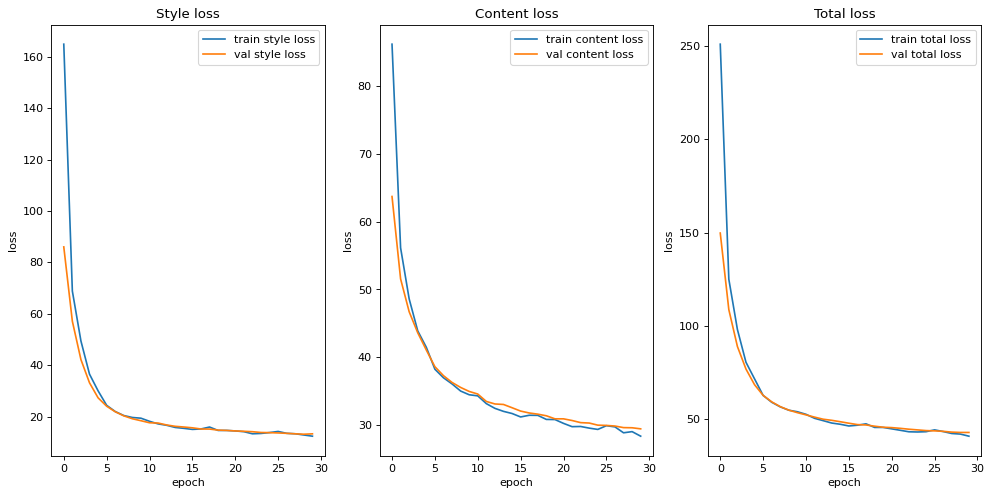

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,15))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7), dpi=80, sharex=False, sharey=False)


ax[0].plot(history.history['style_loss'])
ax[0].plot(history.history['val_style_loss'])
ax[0].set_title('Style loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train style loss', 'val style loss'], loc='upper right')

ax[1].plot(history.history['content_loss'])
ax[1].plot(history.history['val_content_loss'])
ax[1].set_title('Content loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train content loss', 'val content loss'], loc='upper right')

ax[2].plot(history.history['total_loss'])
ax[2].plot(history.history['val_total_loss'])
ax[2].set_title('Total loss')
ax[2].set_ylabel('loss')
ax[2].set_xlabel('epoch')
ax[2].legend(['train total loss', 'val total loss'], loc='upper right')

In [36]:
model.save_weights('/workspace/style/litter_style_checkpoint')

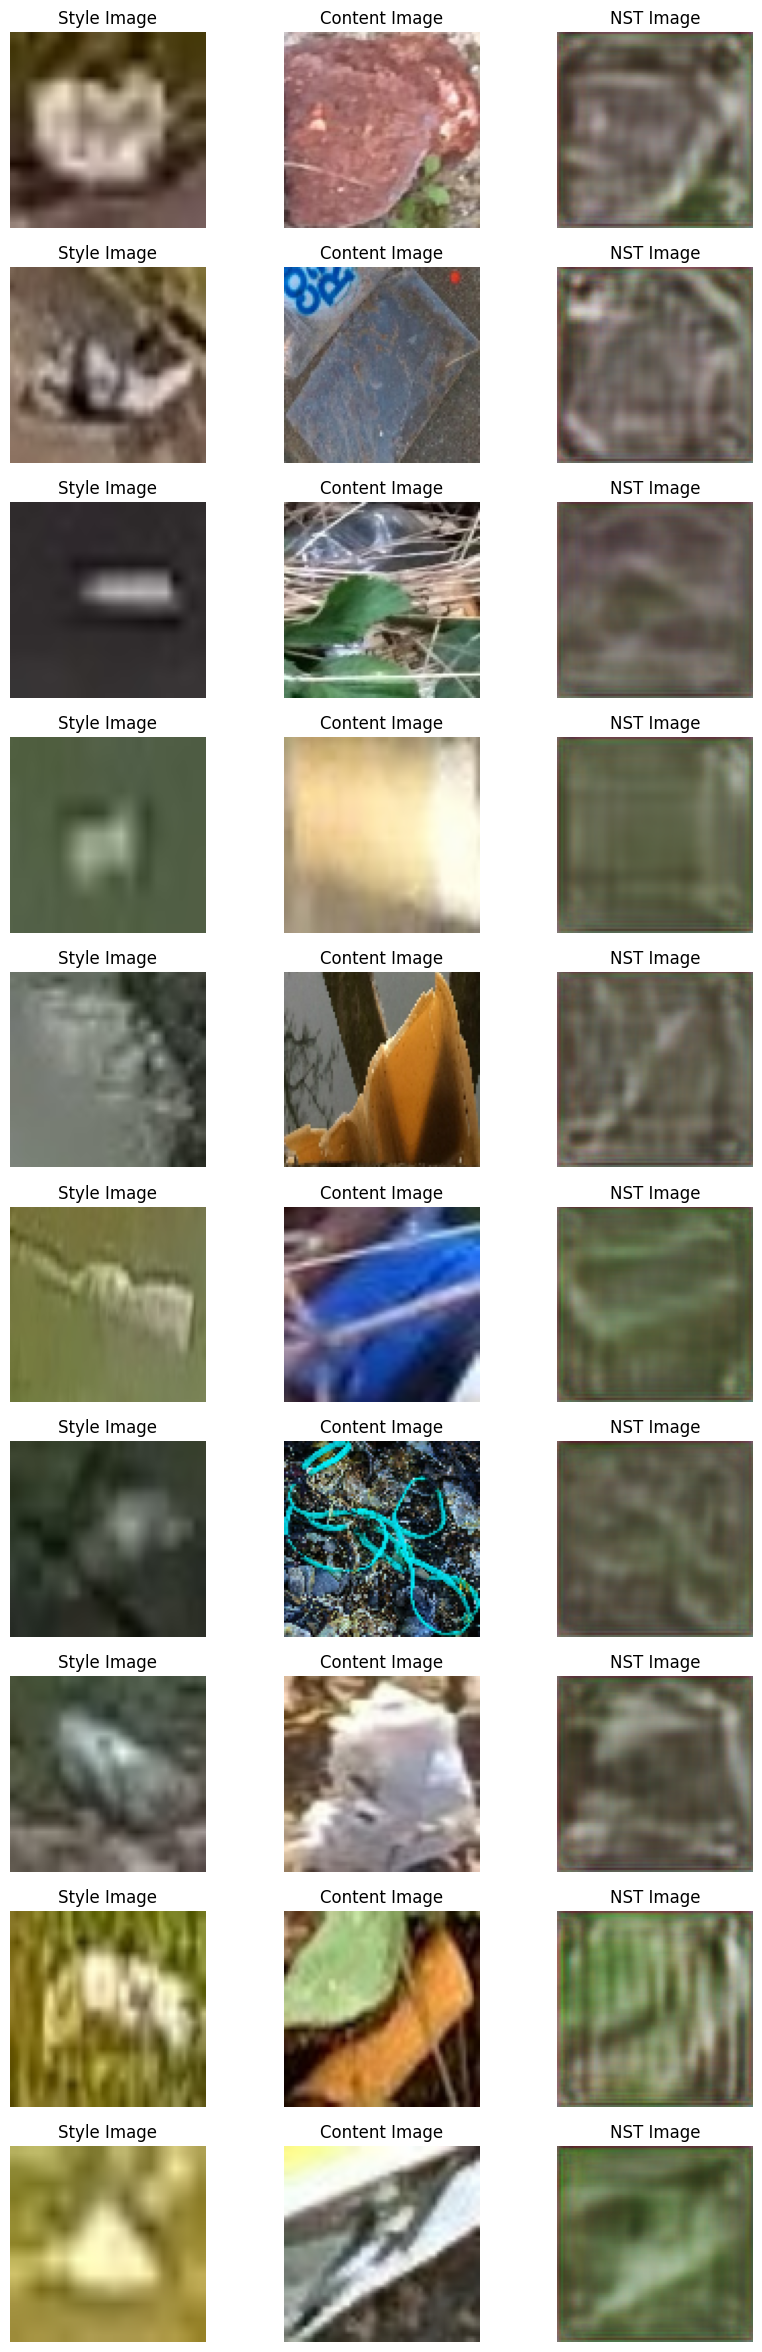

In [19]:
for style, content in test_ds.take(1):
    style_encoded = model.encoder(style)
    content_encoded = model.encoder(content)
    t = ada_in(style=style_encoded, content=content_encoded)
    reconstructed_image = model.decoder(t)
    fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 30))
    [ax.axis("off") for ax in np.ravel(axes)]

    for axis, style_image, content_image, reconstructed_image in zip(
        axes, style[0:10], content[0:10], reconstructed_image[0:10]
    ):
        (ax_style, ax_content, ax_reconstructed) = axis
        ax_style.imshow(style_image)
        ax_style.set_title("Style Image")
        ax_content.imshow(content_image)
        ax_content.set_title("Content Image")
        ax_reconstructed.imshow(reconstructed_image)
        ax_reconstructed.set_title("NST Image")

In [41]:
model.load_weights('/workspace/style/litter_style_checkpoint')

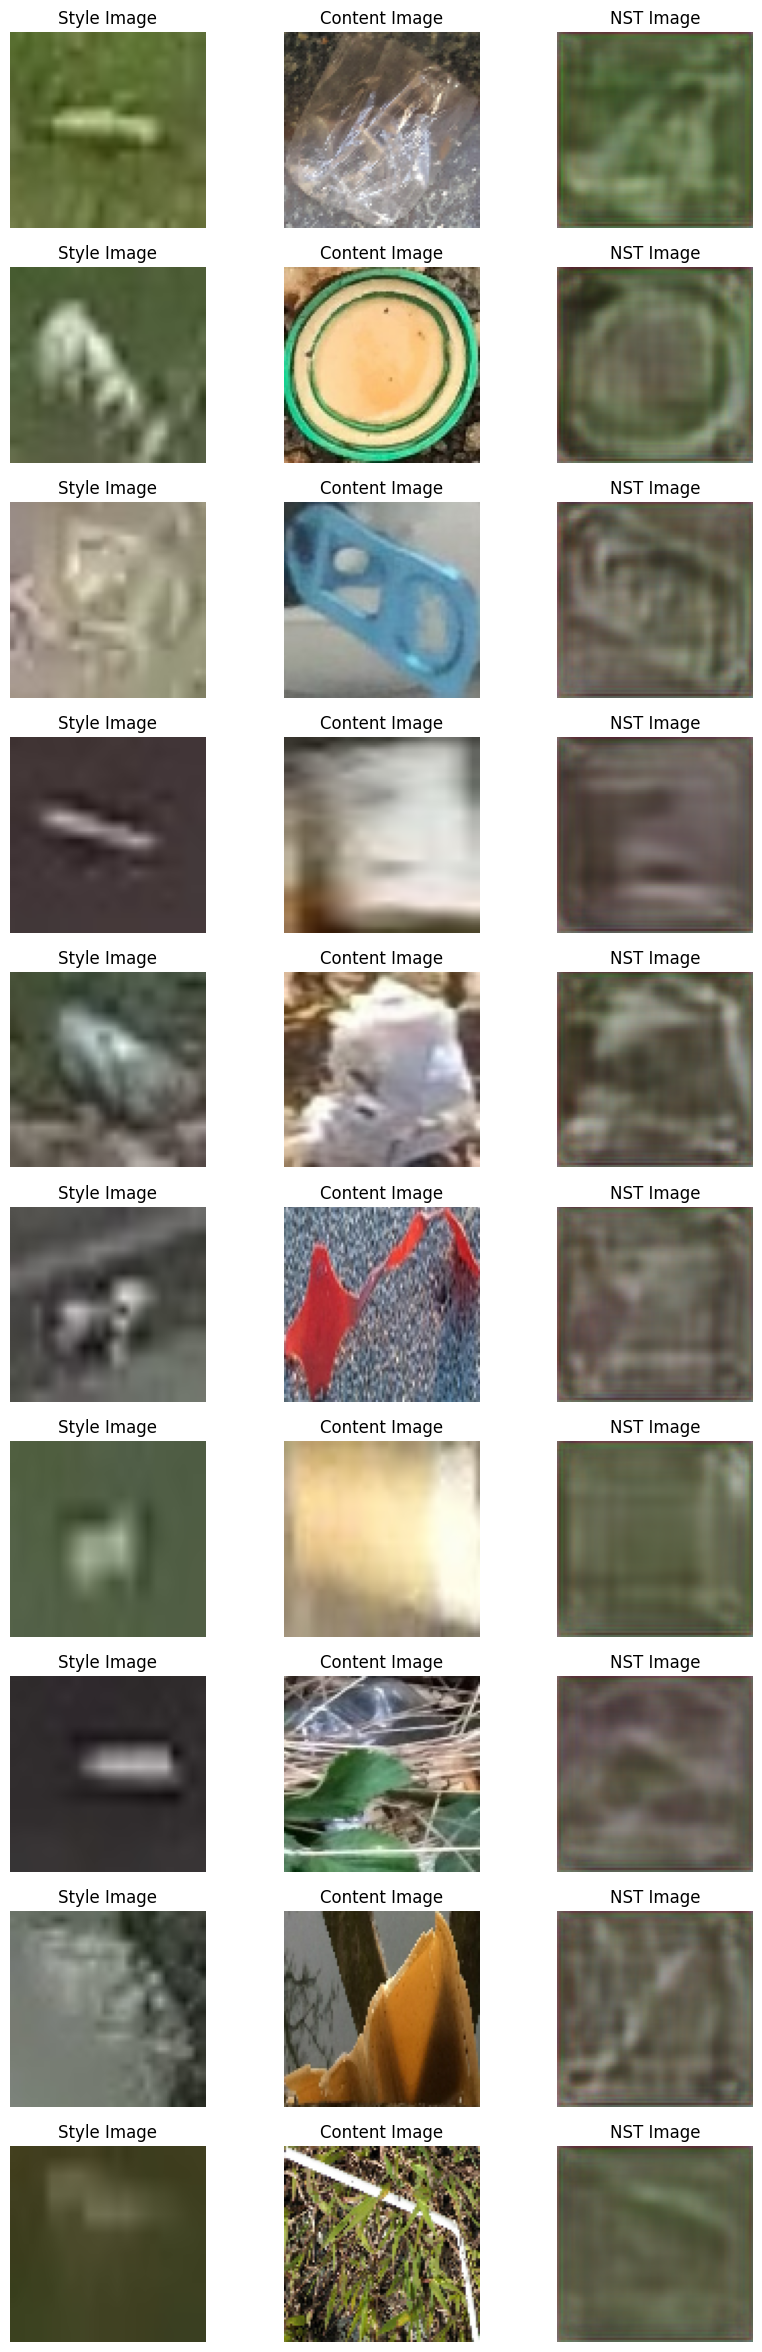

In [42]:
for style, content in test_ds.take(1):
    style_encoded = model.encoder(style)
    content_encoded = model.encoder(content)
    t = ada_in(style=style_encoded, content=content_encoded)
    reconstructed_image = model.decoder(t)
    fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 30))
    [ax.axis("off") for ax in np.ravel(axes)]

    for axis, style_image, content_image, reconstructed_image in zip(
        axes, style[0:10], content[0:10], reconstructed_image[0:10]
    ):
        (ax_style, ax_content, ax_reconstructed) = axis
        ax_style.imshow(style_image)
        ax_style.set_title("Style Image")
        ax_content.imshow(content_image)
        ax_content.set_title("Content Image")
        ax_reconstructed.imshow(reconstructed_image)
        ax_reconstructed.set_title("NST Image")